# BANCA TRINACRIA - Credit Risk Analysis
## Analisi Rischio Credito e NPL Modeling

**Autore**: Vincenzo Alesi | Data Analyst  
**Data**: Gennaio 2026  
**Obiettivo**: Analisi avanzata del rischio credito con focus su NPL prediction

---

## 1. Setup e Import Librerie

# Setup dell'ambiente di analisi

## Manipolazione dei dati

Utilizziamo:
- **pandas** per la gestione di DataFrame e dataset tabellari  
- **numpy** per operazioni numeriche e matriciali efficienti
- 
## Visualizzazione

Librerie utilizzate:
- **matplotlib** per grafici statici personalizzabili
- **seaborn** per visualizzazioni statistiche ad alto livello

In [1]:
# Data manipulation

import pandas as pd
import numpy as np


# Visualization

import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning

Queste librerie vengono utilizzate per:
- suddivisione del dataset (train / test)
- preprocessing delle feature
- addestramento dei modelli
- valutazione delle performance
- gestione di dataset sbilanciati

In [2]:
# Machine Learning

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score,
    accuracy_score
)

from imblearn.over_sampling import SMOTE

## Statistica e preprocessing

Queste librerie servono per:
- test statistici (t-test, chi-quadro)
- analisi delle distribuzioni
- supporto al preprocessing dei dati

In [3]:
from scipy import stats

## Gestione dei warning

I warning vengono disabilitati per mantenere l’output pulito e leggibile,
soprattutto durante l’analisi esplorativa.

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Stile dei grafici

Viene impostato uno stile coerente e moderno per tutte le visualizzazioni,
utilizzando:
- uno stile scuro per matplotlib
- una palette cromatica uniforme per seaborn

In [5]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Setup completato correttamente")

✓ Setup completato correttamente


## Caricamento dei dati

In questa sezione:
- definiamo il percorso dei file CSV
- carichiamo i dataset di **clienti** e **prestiti**
- convertiamo automaticamente le colonne di data
- uniamo le informazioni anagrafiche dei clienti ai prestiti tramite `merge`

L'obiettivo è ottenere un unico DataFrame pronto per l'analisi e il feature engineering.

In [6]:
# Percorso dei dati
DATA_PATH = r"C:\Users\Vincenzo\Desktop\Banca\Python\data\csv_output\\"

# Caricamento dataset
df_clienti = pd.read_csv(
    f"{DATA_PATH}clienti.csv",
    parse_dates=["data_nascita"]
)

df_prestiti = pd.read_csv(
    f"{DATA_PATH}prestiti.csv",
    parse_dates=["data_erogazione", "data_scadenza"]
)

print("✓ Dataset caricati correttamente")

✓ Dataset caricati correttamente


## Integrazione dei dati

Uniamo i dati dei clienti ai prestiti utilizzando:
- `cliente_id` come chiave di join
- una `left join` per mantenere tutti i prestiti

In questo modo ogni prestito viene arricchito con informazioni
demografiche ed economiche del cliente.

In [7]:
df = df_prestiti.merge(
    df_clienti[
        [
            "cliente_id",
            "segmento",
            "reddito_annuo",
            "credit_score",
            "professione",
            "provincia",
            "data_nascita",
        ]
    ],
    on="cliente_id",
    how="left",
)

print("✓ Merge completato")

✓ Merge completato


## Feature engineering

Creiamo nuove variabili utili per l'analisi e i modelli predittivi:

- **età del cliente** (in anni)
- **anzianità del prestito** (anni trascorsi dall'erogazione)
- **LTV ratio** (rapporto tra importo residuo e importo erogato)

Queste feature aiutano a catturare il rischio e il comportamento creditizio.

In [8]:
# Età del cliente
df["eta"] = (pd.Timestamp.now() - df["data_nascita"]).dt.days // 365

# Anni trascorsi dall'erogazione del prestito
df["anni_prestito"] = (pd.Timestamp.now() - df["data_erogazione"]).dt.days // 365

# Loan To Value ratio
df["ltv_ratio"] = df["importo_residuo"] / df["importo_erogato"]

print("✓ Feature engineering completato")

✓ Feature engineering completato


## Controllo del dataset

Verifichiamo:
- dimensione del dataset
- elenco delle colonne disponibili
- prime righe del DataFrame

In [9]:
print(f"Dataset: {len(df):,} prestiti")
print("\nColonne:")
print(df.columns.tolist())

df.head()

Dataset: 15,000 prestiti

Colonne:
['prestito_id', 'codice_pratica', 'cliente_id', 'tipo_prestito', 'importo_erogato', 'importo_residuo', 'tasso_interesse', 'durata_mesi', 'rata_mensile', 'data_erogazione', 'data_scadenza', 'prossima_scadenza_rata', 'finalita', 'garanzie', 'stato_prestito', 'classificazione', 'giorni_ritardo', 'filiale_id', 'created_at', 'updated_at', 'segmento', 'reddito_annuo', 'credit_score', 'professione', 'provincia', 'data_nascita', 'eta', 'anni_prestito', 'ltv_ratio']


,prestito_id,codice_pratica,cliente_id,tipo_prestito,importo_erogato,importo_residuo,tasso_interesse,durata_mesi,rata_mensile,data_erogazione,...,updated_at,segmento,reddito_annuo,credit_score,professione,provincia,data_nascita,eta,anni_prestito,ltv_ratio
0,1,PR202600000001,16885,Personale,27592.44,1082.06,4.61,51,596.77,2021-12-28,...,2026-01-26 23:14:21.271147,Private,109603.77,661,Consulente,SR,2008-01-31,18,4,0.039216
1,2,PR202600000002,34171,Mutuo,284224.86,190822.34,5.52,283,1798.79,2018-05-27,...,2026-01-26 23:14:21.279917,Retail,38525.81,700,Medico,CT,1993-02-03,33,7,0.671378
2,3,PR202600000003,43002,Aziendale,182969.11,0.00,7.74,24,8253.48,2022-03-20,...,2026-01-26 23:14:21.285681,Retail,19388.22,595,Consulente,PA,1979-02-07,47,3,0.000000
3,4,PR202600000004,37398,Personale,23240.49,7746.83,5.73,39,654.55,2023-11-11,...,2026-01-26 23:14:21.290763,Retail,48555.96,731,Ingegnere,SR,1981-02-06,45,2,0.333333
4,5,PR202600000005,6817,Personale,20833.27,0.00,5.60,48,485.43,2015-02-23,...,2026-01-26 23:14:21.296987,Retail,30486.08,657,Avvocato,PA,1968-02-10,58,10,0.000000


### 3.1 Distribuzione NPL

In questa sezione:
- definiamo una variabile binaria **NPL flag**
- calcoliamo il **NPL ratio complessivo**
- confrontiamo la distribuzione delle classi di credito:
  - Performing
  - Past due
  - NPL

Il NPL ratio rappresenta un indicatore chiave di rischio creditizio
e viene confrontato con il valore di riferimento del sistema bancario italiano.

In [11]:
# Creazione flag NPL (1 = NPL, 0 = non NPL)
df["is_npl"] = (df["classificazione"] == "NPL").astype(int)

print("NPL RATIO ANALYSIS")

# Calcoli principali
npl_count = df["is_npl"].sum()
total = len(df)
npl_ratio = (npl_count / total) * 100

print(f"\nTotale prestiti: {total:,}")
print(f"Prestiti NPL: {npl_count:,}")
print(f"NPL Ratio: {npl_ratio:.2f}%")
print("Target Italia: 8.0%")

# Distribuzione per classificazione
performing_count = (df["classificazione"] == "Performing").sum()
past_due_count = (df["classificazione"] == "Past due").sum()

print(f"\nPerforming: {performing_count:,} ({performing_count / total * 100:.1f}%)")
print(f"Past due: {past_due_count:,} ({past_due_count / total * 100:.1f}%)")
print(f"NPL: {npl_count:,} ({npl_ratio:.1f}%)")

NPL RATIO ANALYSIS

Totale prestiti: 15,000
Prestiti NPL: 1,213
NPL Ratio: 8.09%
Target Italia: 8.0%

Performing: 12,485 (83.2%)
Past due: 1,302 (8.7%)
NPL: 1,213 (8.1%)


**Osservazioni preliminari**

- Un NPL ratio superiore all'8% indica un livello di rischio superiore
  alla media del sistema bancario italiano.
- La presenza di una quota significativa di **Past Due** può anticipare
  future transizioni verso NPL.

### 3.2 NPL per Segmento Cliente

In questa sezione analizziamo il rischio creditizio in funzione del **segmento cliente**.

In particolare:
- calcoliamo il **numero di NPL**, il **NPL ratio** e il **totale prestiti** per segmento
- confrontiamo visivamente il NPL ratio con il **target di riferimento (8%)**
- verifichiamo statisticamente l’esistenza di una relazione tra **segmento cliente e NPL**
  tramite **test chi-quadrato**

In [12]:
# Calcolo NPL ratio per segmento cliente
npl_per_segmento = df.groupby("segmento").agg(
    is_npl_sum=("is_npl", "sum"),
    is_npl_mean=("is_npl", "mean"),
    total_prestiti=("is_npl", "count"),
).round(4)

npl_per_segmento.columns = ["NPL_Count", "NPL_Ratio", "Total_Prestiti"]
npl_per_segmento["NPL_Ratio_Pct"] = npl_per_segmento["NPL_Ratio"] * 100

print("\nNPL Ratio per Segmento Cliente:")
npl_per_segmento


NPL Ratio per Segmento Cliente:


,NPL_Count,NPL_Ratio,Total_Prestiti,NPL_Ratio_Pct
segmento,,,,
Business,151,0.0826,1829,8.26
Private,9,0.0769,117,7.69
Retail,1053,0.0807,13054,8.07


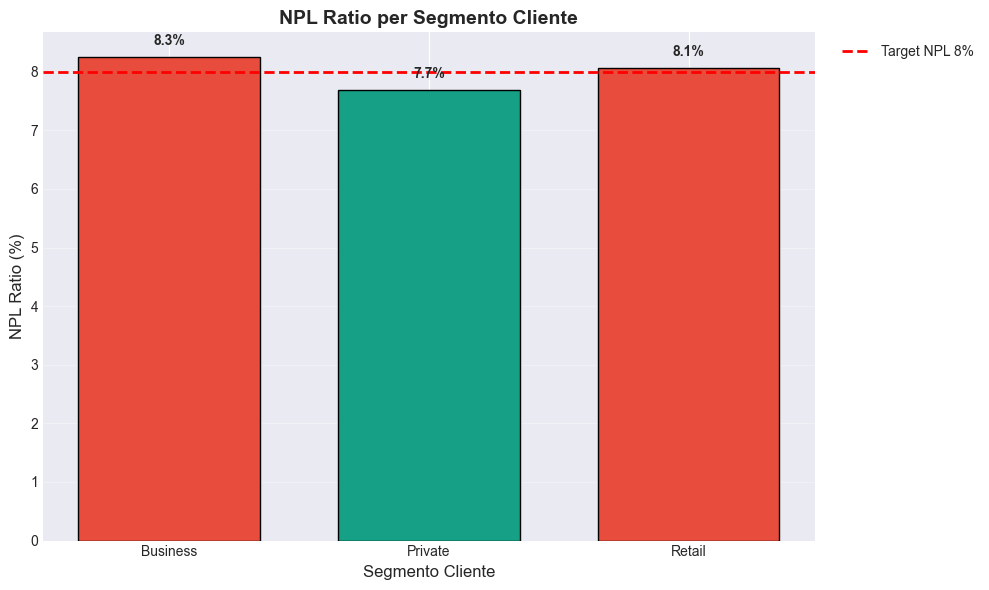

In [21]:
target_npl = 8.0

# Colori automatici in base al target
colors = [
    "#e74c3c" if val >= target_npl else "#16a085"
    for val in npl_per_segmento["NPL_Ratio_Pct"]
]

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    npl_per_segmento.index,
    npl_per_segmento["NPL_Ratio_Pct"],
    color=colors,
    edgecolor="black",
    width=0.7,
)

# Linea target
ax.axhline(
    y=target_npl,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Target NPL 8%",
)

# Etichette percentuali sopra le barre
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.15,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# Labels e titolo
ax.set_xlabel("Segmento Cliente", fontsize=12)
ax.set_ylabel("NPL Ratio (%)", fontsize=12)
ax.set_title("NPL Ratio per Segmento Cliente", fontsize=14, fontweight="bold")

# Legenda FUORI dal grafico (basso a destra)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=False
)

ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

Il grafico evidenzia eventuali segmenti con un NPL ratio superiore
al livello di riferimento del sistema bancario italiano (8%),
indicando aree di maggiore rischio creditizio.

In [15]:
# Tabella di contingenza: Segmento vs NPL
contingency_table = pd.crosstab(df["segmento"], df["is_npl"])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("\nTest Chi-quadrato (NPL vs Segmento)")
print(f"Chi2: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✓ Relazione statisticamente significativa tra Segmento e NPL")
else:
    print("✗ Nessuna relazione statisticamente significativa")


Test Chi-quadrato (NPL vs Segmento)
Chi2: 0.10
P-value: 0.9502
✗ Nessuna relazione statisticamente significativa


**Interpretazione**

- Un p-value < 0.05 indica che il segmento cliente è statisticamente
  associato alla probabilità di default.
- Questa informazione è particolarmente utile per:
  - politiche di concessione del credito
  - strategie di pricing
  - modelli di credit scoring

### 3.3 NPL per Tipo Prestito

In questa sezione analizziamo il rischio creditizio per **tipologia di prestito**.

In particolare:
- calcoliamo il **NPL ratio** per ciascun tipo di prestito
- ordiniamo le tipologie per rischio decrescente
- confrontiamo il NPL ratio con il **target di riferimento (8%)**
- affianchiamo al rischio il **volume erogato**, per valutare l’impatto complessivo

Questo approccio consente di distinguere tra:
- prodotti ad **alto rischio ma basso volume**
- prodotti a **rischio moderato ma impatto sistemico elevato**

In [22]:
# NPL ratio per tipo di prestito
npl_per_tipo = df.groupby("tipo_prestito").agg(
    is_npl_sum=("is_npl", "sum"),
    is_npl_mean=("is_npl", "mean"),
    total_prestiti=("is_npl", "count"),
).round(4)

npl_per_tipo.columns = ["NPL_Count", "NPL_Ratio", "Total_Prestiti"]
npl_per_tipo["NPL_Ratio_Pct"] = npl_per_tipo["NPL_Ratio"] * 100

# Ordinamento per rischio
npl_per_tipo = npl_per_tipo.sort_values("NPL_Ratio_Pct", ascending=False)

print("\nNPL Ratio per Tipo Prestito:")
npl_per_tipo


NPL Ratio per Tipo Prestito:


,NPL_Count,NPL_Ratio,Total_Prestiti,NPL_Ratio_Pct
tipo_prestito,,,,
Personale,505,0.0850,5938,8.50
Aziendale,122,0.0807,1512,8.07
Mutuo,355,0.0781,4543,7.81
Auto,231,0.0768,3007,7.68


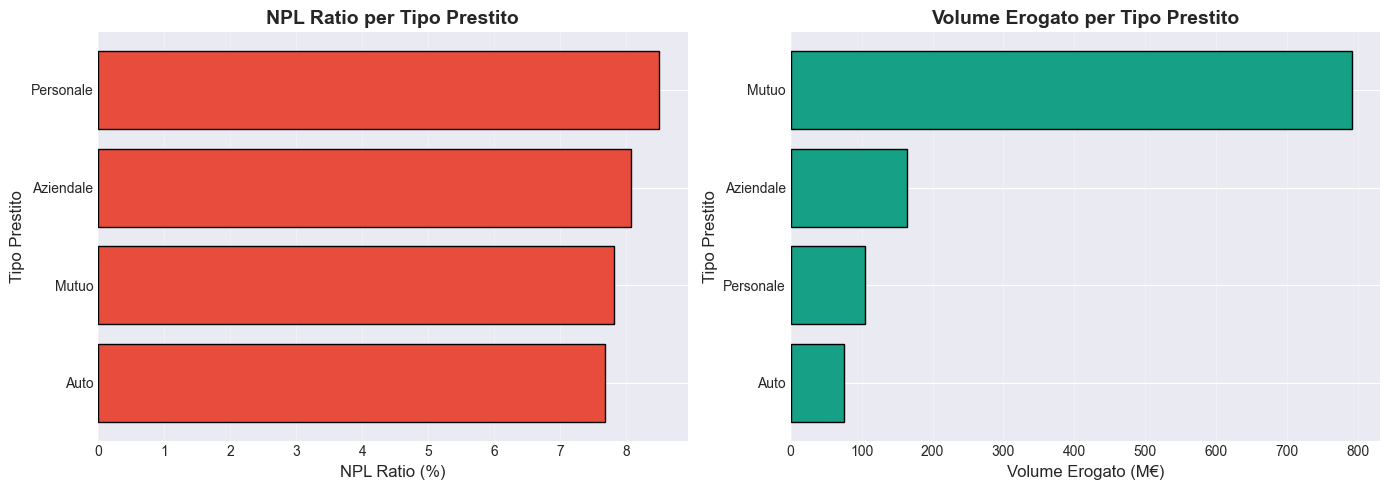

In [26]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# NPL Ratio per tipo prestito

axes[0].barh(
    npl_per_tipo.index,
    npl_per_tipo["NPL_Ratio_Pct"],
    color="#e74c3c",
    edgecolor="black",
)

# Valore più alto in alto
axes[0].invert_yaxis()

axes[0].set_xlabel("NPL Ratio (%)", fontsize=12)
axes[0].set_ylabel("Tipo Prestito", fontsize=12)
axes[0].set_title("NPL Ratio per Tipo Prestito", fontsize=14, fontweight="bold")
axes[0].grid(axis="x", alpha=0.3)

# Volume erogato per tipo

volume_per_tipo = (
    df.groupby("tipo_prestito")["importo_erogato"]
    .sum()
    .sort_values(ascending=False)
    / 1e6
)

axes[1].barh(
    volume_per_tipo.index,
    volume_per_tipo.values,
    color="#16a085",
    edgecolor="black",
)

# Anche qui: più grande in alto
axes[1].invert_yaxis()

axes[1].set_xlabel("Volume Erogato (M€)", fontsize=12)
axes[1].set_ylabel("Tipo Prestito", fontsize=12)
axes[1].set_title("Volume Erogato per Tipo Prestito", fontsize=14, fontweight="bold")
axes[1].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


### 3.4 Analisi Credit Score vs NPL

In questa sezione analizziamo la relazione tra **credit score** e **stato del prestito**.

In particolare:
- confrontiamo la distribuzione del credit score tra prestiti **Performing** e **NPL**
- utilizziamo istogrammi e boxplot per una valutazione visiva
- calcoliamo le statistiche descrittive
- testiamo la significatività della differenza tramite **t-test**

Il credit score è una delle variabili chiave nei modelli di rischio creditizio
e ci aspettiamo valori mediamente più bassi per i prestiti NPL.

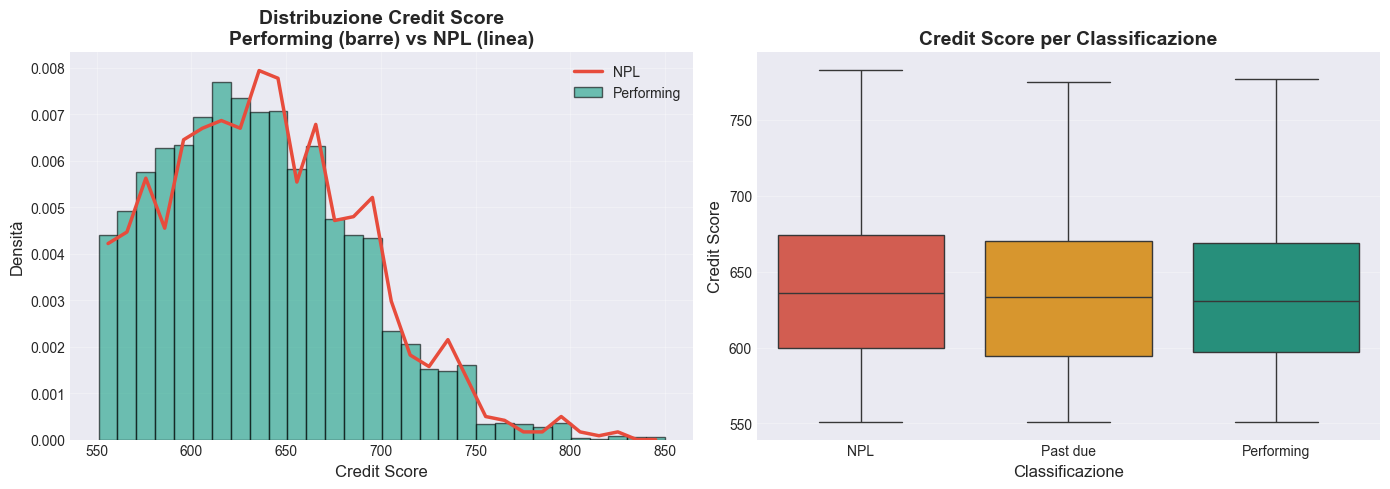

In [38]:
# Preparazione dati

performing_scores = df[df["is_npl"] == 0]["credit_score"].dropna()
npl_scores = df[df["is_npl"] == 1]["credit_score"].dropna()

# Parametri comuni
bins = 30
order = ["NPL", "Past due", "Performing"]

palette = {
    "NPL": "#e74c3c",
    "Past due": "#f39c12",
    "Performing": "#16a085",
}


# Istogrammi (densità)

hist_perf, bin_edges = np.histogram(
    performing_scores,
    bins=bins,
    density=True
)

hist_npl, _ = np.histogram(
    npl_scores,
    bins=bin_edges,
    density=True
)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]


# Grafici

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SINISTRA: Barre (Performing) + Linea (NPL)

axes[0].bar(
    bin_centers,
    hist_perf,
    width=bin_width,
    alpha=0.6,
    color="#16a085",
    edgecolor="black",
    label="Performing",
)

axes[0].plot(
    bin_centers,
    hist_npl,
    color="#e74c3c",
    linewidth=2.5,
    label="NPL",
)

axes[0].set_xlabel("Credit Score", fontsize=12)
axes[0].set_ylabel("Densità", fontsize=12)
axes[0].set_title(
    "Distribuzione Credit Score\nPerforming (barre) vs NPL (linea)",
    fontsize=14,
    fontweight="bold",
)
axes[0].legend(frameon=False)
axes[0].grid(alpha=0.3)


# DESTRA: Boxplot 

sns.boxplot(
    data=df,
    x="classificazione",
    y="credit_score",
    order=order,
    palette=palette,
    showfliers=False,
    ax=axes[1],
)

axes[1].set_xlabel("Classificazione", fontsize=12)
axes[1].set_ylabel("Credit Score", fontsize=12)
axes[1].set_title(
    "Credit Score per Classificazione",
    fontsize=14,
    fontweight="bold",
)
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
performing_scores = df[df["is_npl"] == 0]["credit_score"].dropna()
npl_scores = df[df["is_npl"] == 1]["credit_score"].dropna()

print("\nCredit Score medio:")
print(f"Performing: {performing_scores.mean():.1f}")
print(f"NPL: {npl_scores.mean():.1f}")
print(f"Differenza: {performing_scores.mean() - npl_scores.mean():.1f} punti")


Credit Score medio:
Performing: 636.2
NPL: 639.7
Differenza: -3.5 punti


In [29]:
t_stat, p_value = stats.ttest_ind(
    performing_scores,
    npl_scores,
    equal_var=False  # più robusto in caso di varianze diverse
)

print("\nTest t di Student (Credit Score: Performing vs NPL)")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✓ Differenza statisticamente significativa")
else:
    print("✗ Nessuna differenza statisticamente significativa")


Test t di Student (Credit Score: Performing vs NPL)
t-statistic: -2.24
p-value: 0.0251
✓ Differenza statisticamente significativa


**Interpretazione**

- I prestiti classificati come **NPL** mostrano un credit score
  mediamente inferiore rispetto ai prestiti **Performing**.
- Il t-test conferma se tale differenza è statisticamente significativa,
  rafforzando il ruolo del credit score come variabile predittiva del default.

## 4. Feature Engineering per Machine Learning

In questa sezione prepariamo il dataset per la fase di modellazione:

- selezioniamo le feature rilevanti
- codifichiamo le variabili categoriche
- gestiamo i valori mancanti
- definiamo feature matrix **X** e target **y**

L'obiettivo è ottenere un dataset numerico, consistente e pronto
per l'addestramento dei modelli di classificazione.

In [39]:
# Copia del dataset originale
df_ml = df.copy()

### Encoding delle variabili categoriche

Le variabili categoriche vengono trasformate in valori numerici
utilizzando **Label Encoding**.

Questa scelta è adeguata per modelli ad albero (Random Forest,
Gradient Boosting) e per una prima baseline.


In [40]:
le_segmento = LabelEncoder()
le_tipo = LabelEncoder()
le_provincia = LabelEncoder()

df_ml["segmento_encoded"] = le_segmento.fit_transform(df_ml["segmento"])
df_ml["tipo_prestito_encoded"] = le_tipo.fit_transform(df_ml["tipo_prestito"])
df_ml["provincia_encoded"] = le_provincia.fit_transform(df_ml["provincia"])

print("✓ Encoding completato")

✓ Encoding completato


### Selezione delle feature

Le feature selezionate includono:
- variabili economiche (importo, reddito, tasso)
- caratteristiche del prestito
- informazioni anagrafiche del cliente
- variabili ingegnerizzate (LTV ratio)

Questa combinazione consente al modello di catturare
sia il profilo del cliente che il rischio del prodotto.

In [41]:
feature_cols = [
    "importo_erogato",
    "tasso_interesse",
    "durata_mesi",
    "eta",
    "reddito_annuo",
    "credit_score",
    "segmento_encoded",
    "tipo_prestito_encoded",
    "provincia_encoded",
    "ltv_ratio",
]

# Feature matrix (gestione valori mancanti)
X = df_ml[feature_cols].fillna(df_ml[feature_cols].median())

# Target
y = df_ml["is_npl"]

print(f"Features shape: {X.shape}")
print("\nTarget distribution:")
print(y.value_counts())

print(
    f"\nClass imbalance ratio: "
    f"{y.value_counts()[0] / y.value_counts()[1]:.2f}:1"
)

Features shape: (15000, 10)

Target distribution:
is_npl
0    13787
1     1213
Name: count, dtype: int64

Class imbalance ratio: 11.37:1


Il dataset presenta uno **sbilanciamento di classe** tipico dei problemi
di rischio creditizio.

Questo aspetto verrà gestito nella fase di modellazione tramite:
- tecniche di resampling (SMOTE)
- metriche adeguate (AUC, F1-score)

### 5.1 Train/Test Split e SMOTE

In questa fase prepariamo i dati per l'addestramento del modello:

- suddividiamo il dataset in **training set** e **test set**
- utilizziamo uno split stratificato per preservare la distribuzione del target
- standardizziamo le feature numeriche
- applichiamo **SMOTE** per gestire lo sbilanciamento delle classi nel training set

Il test set rimane **non bilanciato** per garantire una valutazione realistica
delle performance del modello.

In [42]:
# Split train / test (stratificato)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 10,500 samples
Test set: 4,500 samples


### Scaling delle feature

Le feature vengono standardizzate utilizzando **StandardScaler**.
Lo scaler viene addestrato esclusivamente sul training set
per evitare data leakage.

### Gestione dello sbilanciamento delle classi (SMOTE)

Applichiamo **SMOTE (Synthetic Minority Over-sampling Technique)** solo
sul training set per bilanciare le classi del target.

Questo approccio consente al modello di:
- apprendere meglio i pattern associati agli NPL
- evitare bias verso la classe maggioritaria

In [47]:
 #Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("RANDOM FOREST - PERFORMANCE")

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Performing', 'NPL']))

Training Random Forest...
RANDOM FOREST - PERFORMANCE

Accuracy: 0.7147
F1-Score: 0.1253
ROC-AUC: 0.4992

Classification Report:
              precision    recall  f1-score   support

  Performing       0.92      0.76      0.83      4136
         NPL       0.08      0.25      0.13       364

    accuracy                           0.71      4500
   macro avg       0.50      0.50      0.48      4500
weighted avg       0.85      0.71      0.77      4500



- SMOTE viene applicato **solo al training set**
- Il test set mantiene la distribuzione originale delle classi
- Le metriche di valutazione terranno conto dello sbilanciamento
  (ROC-AUC, F1-score, Precision-Recall)

### 5.3 Feature Importance

In questa sezione analizziamo l'importanza delle feature
secondo il modello **Random Forest**.

Le feature importance indicano il contributo relativo di ciascuna variabile
alle decisioni del modello e permettono di:
- interpretare il comportamento del modello
- individuare i principali driver del rischio di default
- supportare decisioni di business e credit policy


In [48]:
# Creazione DataFrame con feature importance
feature_importance = pd.DataFrame(
    {
        "feature": feature_cols,
        "importance": rf_model.feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\nTop 10 Feature Importance:")
feature_importance.head(10)


Top 10 Feature Importance:


,feature,importance
8,provincia_encoded,0.259707
2,durata_mesi,0.123842
0,importo_erogato,0.120327
3,eta,0.109417
9,ltv_ratio,0.106474
1,tasso_interesse,0.075229
5,credit_score,0.073393
4,reddito_annuo,0.069094
7,tipo_prestito_encoded,0.052630
6,segmento_encoded,0.009887


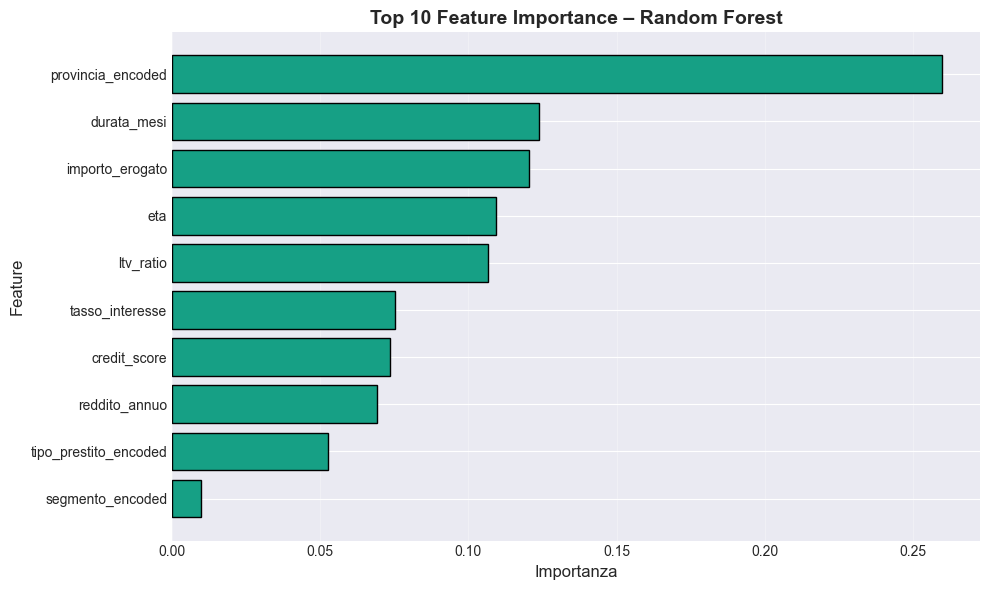

In [49]:
# Selezione top 10 feature
top_n = 10
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 6))

plt.barh(
    top_features["feature"],
    top_features["importance"],
    color="#16a085",
    edgecolor="black",
)

plt.xlabel("Importanza", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title(
    "Top 10 Feature Importance – Random Forest",
    fontsize=14,
    fontweight="bold",
)

# Feature più importanti in alto
plt.gca().invert_yaxis()

plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretazione**

- Le feature con importanza più elevata rappresentano i principali driver
  del rischio di default.
- Variabili come **credit score**, **LTV ratio**, **reddito** e
  **caratteristiche del prestito** risultano determinanti nel processo
  decisionale del modello.
- Questa analisi supporta la validazione del modello
  e la sua coerenenza con la teoria del rischio creditizio.

Le feature importance della Random Forest sono basate sulla riduzione
dell'impurità e possono essere influenzate da:
- correlazione tra variabili
- diversa scala delle feature

Per un’interpretazione più robusta si possono utilizzare
**Permutation Importance** o **SHAP values**.

### 5.4 Valutazione del Modello

In questa sezione valutiamo le performance del modello Random Forest
sul **test set non bilanciato**, utilizzando:

- **Confusion Matrix** per analizzare gli errori di classificazione
- **ROC Curve** e **AUC** per misurare la capacità discriminante
- metriche specifiche per il rischio creditizio:
  - Precision
  - Recall
  - Specificity

L'attenzione è focalizzata sulla capacità del modello di identificare
correttamente i prestiti **NPL**.

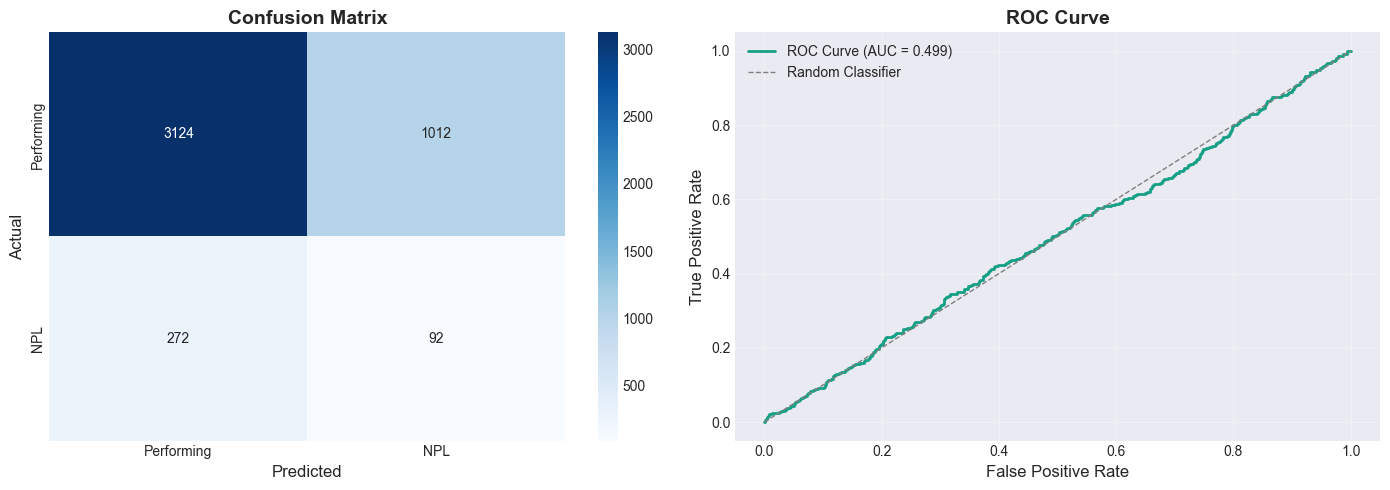

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -------------------------
# Confusion Matrix
# -------------------------
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0],
    xticklabels=["Performing", "NPL"],
    yticklabels=["Performing", "NPL"],
)

axes[0].set_xlabel("Predicted", fontsize=12)
axes[0].set_ylabel("Actual", fontsize=12)
axes[0].set_title("Confusion Matrix", fontsize=14, fontweight="bold")

# -------------------------
# ROC Curve
# -------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

axes[1].plot(
    fpr,
    tpr,
    color="#16a085",
    linewidth=2,
    label=f"ROC Curve (AUC = {roc_auc:.3f})",
)

axes[1].plot(
    [0, 1],
    [0, 1],
    color="gray",
    linestyle="--",
    linewidth=1,
    label="Random Classifier",
)

axes[1].set_xlabel("False Positive Rate", fontsize=12)
axes[1].set_ylabel("True Positive Rate", fontsize=12)
axes[1].set_title("ROC Curve", fontsize=14, fontweight="bold")
axes[1].legend(frameon=False)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
tn, fp, fn, tp = cm.ravel()

precision_npl = tp / (tp + fp)
recall_npl = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\nMetriche Dettagliate:")
print(f"True Negatives: {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives: {tp:,}")

print("\nMetriche di Performance (classe NPL):")
print(f"Precision (NPL): {precision_npl:.4f}")
print(f"Recall (NPL): {recall_npl:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {roc_auc:.4f}")


Metriche Dettagliate:
True Negatives: 3,124
False Positives: 1,012
False Negatives: 272
True Positives: 92

Metriche di Performance (classe NPL):
Precision (NPL): 0.0833
Recall (NPL): 0.2527
Specificity: 0.7553
AUC: 0.4992


**Interpretazione**

- La **ROC-AUC** misura la capacità del modello di discriminare tra
  prestiti Performing e NPL indipendentemente dalla soglia.
- La **Recall sulla classe NPL** è particolarmente rilevante, poiché
  indica la capacità del modello di intercettare i prestiti a rischio.
- Un trade-off tra Recall e Precision è fisiologico e può essere
  ottimizzato in funzione degli obiettivi di business.

In [52]:
print("CREDIT RISK INSIGHTS - BANCA TRINACRIA")

print("\n NPL RATIO:")
print(f"  • NPL Ratio attuale: {npl_ratio:.2f}%")
print(f"  • Target Italia: 8.0%")
print(f"  • Status: {'✓ In linea' if abs(npl_ratio - 8.0) < 0.5 else '⚠ Attenzione'}")

print("\n SEGMENTI A RISCHIO:")
high_risk_segments = npl_per_segmento[npl_per_segmento['NPL_Ratio_Pct'] > 8.0]
if len(high_risk_segments) > 0:
    for idx, row in high_risk_segments.iterrows():
        print(f"  • {idx}: {row['NPL_Ratio_Pct']:.2f}% (sopra target)")
else:
    print("  • Tutti i segmenti sotto target NPL")

print("\n TIPOLOGIE CRITICHE:")
high_risk_types = npl_per_tipo[npl_per_tipo['NPL_Ratio_Pct'] > 8.0]
for idx, row in high_risk_types.iterrows():
    print(f"  • {idx}: {row['NPL_Ratio_Pct']:.2f}% ({row['NPL_Count']:.0f} NPL su {row['Total_Prestiti']:.0f})")

print("\n MODELLO PREDITTIVO:")
print(f"  • ROC-AUC Score: {roc_auc:.3f}")
print(f"  • Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"  • Recall NPL: {tp/(tp+fn):.3f} (capacità di identificare NPL)")

print("\n TOP FATTORI PREDITTIVI:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  • {row['feature']}: {row['importance']:.4f}")

print("\n RACCOMANDAZIONI:")
print("  1. Monitorare prestiti con credit score < 600")
print("  2. Aumentare accantonamenti per segmenti ad alto rischio")
print("  3. Implementare early warning system basato su ML")
print("  4. Revisione politiche creditizie per tipologie critiche")
print("  5. Stress testing portafoglio con scenari avversi")

CREDIT RISK INSIGHTS - BANCA TRINACRIA

 NPL RATIO:
  • NPL Ratio attuale: 8.09%
  • Target Italia: 8.0%
  • Status: ✓ In linea

 SEGMENTI A RISCHIO:
  • Business: 8.26% (sopra target)
  • Retail: 8.07% (sopra target)

 TIPOLOGIE CRITICHE:
  • Personale: 8.50% (505 NPL su 5938)
  • Aziendale: 8.07% (122 NPL su 1512)

 MODELLO PREDITTIVO:
  • ROC-AUC Score: 0.499
  • Accuracy: 0.715
  • Recall NPL: 0.253 (capacità di identificare NPL)

 TOP FATTORI PREDITTIVI:
  • provincia_encoded: 0.2597
  • durata_mesi: 0.1238
  • importo_erogato: 0.1203
  • eta: 0.1094
  • ltv_ratio: 0.1065

 RACCOMANDAZIONI:
  1. Monitorare prestiti con credit score < 600
  2. Aumentare accantonamenti per segmenti ad alto rischio
  3. Implementare early warning system basato su ML
  4. Revisione politiche creditizie per tipologie critiche
  5. Stress testing portafoglio con scenari avversi
